In [2]:

import json,sys,random
import numpy as np

In [3]:
from keras.models import Sequential 
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
import keras.callbacks

In [4]:
from PIL import Image, ImageDraw

In [5]:
from matplotlib import pyplot as plt

In [6]:
f = open('shipsnet.json')
dataset = json.load(f)
f.close()

In [7]:
input_data = np.array(dataset['data']).astype('uint8')
output_data = np.array(dataset['labels']).astype('uint8')

In [8]:
input_data.shape

(4000, 19200)

In [9]:
input_data

array([[ 82,  89,  91, ...,  86,  88,  89],
       [ 76,  75,  67, ...,  54,  57,  58],
       [125, 127, 129, ..., 111, 109, 115],
       ...,
       [171, 135, 118, ...,  95,  95,  85],
       [ 85,  90,  94, ...,  96,  95,  89],
       [122, 122, 126, ...,  51,  46,  69]], dtype=uint8)

In [10]:
input_data[0].shape

(19200,)

In [11]:
n_spectrum = 3 
weight = 80
height = 80
X = input_data.reshape([-1,n_spectrum,weight,height])
X[0].shape

(3, 80, 80)

In [12]:
pic = X[3]

red_spectrum = pic[0]
green_spectrum = pic[1]
blue_spectrum = pic[2]

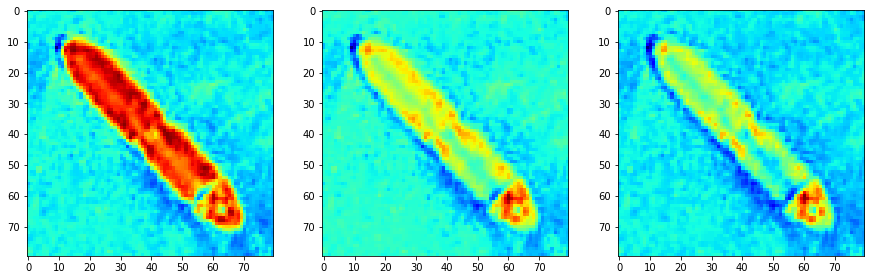

In [13]:
plt.figure(2, figsize = (5*3, 5*1))
plt.set_cmap('jet')

plt.subplot(1, 3, 1)
plt.imshow(red_spectrum)

plt.subplot(1, 3, 2)
plt.imshow(green_spectrum)

plt.subplot(1, 3, 3)
plt.imshow(blue_spectrum)

plt.show()

In [14]:
output_data.shape

(4000,)

In [15]:
output_data

array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)

In [16]:
np.bincount(output_data)

array([3000, 1000], dtype=int64)

In [17]:
#output encoding
y = np_utils.to_categorical(output_data,2)

In [18]:
indexes = np.arange(4000)
np.random.shuffle(indexes)

In [19]:
X_train = X[indexes].transpose([0,2,3,1])
y_train = y[indexes]

In [20]:
# images are type uint8 with values in the [0, 255] interval and we would like to contain values between 0 and 1
X_train = X_train / 255

In [21]:
np.random.seed(42)

In [22]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
model.add(Dropout(0.25))

model.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [1]:
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(
    loss='categorical_crossentropy',
    optimizer=sgd,
    metrics=['accuracy'])

model.fit(
    X_train, 
    y_train,
    batch_size=32,
    epochs=100,
    validation_split=0.2,
    shuffle=True,
    verbose=2)

NameError: name 'SGD' is not defined

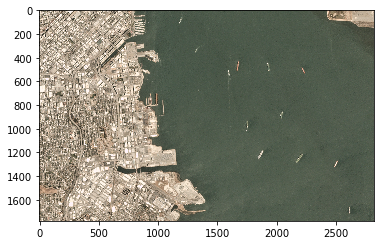

In [35]:
image = Image.open('scenes/sfbay_1.png')
pix = image.load()
plt.imshow(image)

In [36]:

n_spectrum = 3
width = image.size[0]
height = image.size[1]

In [37]:
picture_vector = []
for chanel in range(n_spectrum):
    for y in range(height):
        for x in range(width):
            picture_vector.append(pix[x, y][chanel])

In [38]:
picture_vector = np.array(picture_vector).astype('uint8')
picture_tensor = picture_vector.reshape([n_spectrum, height, width]).transpose(1, 2, 0)

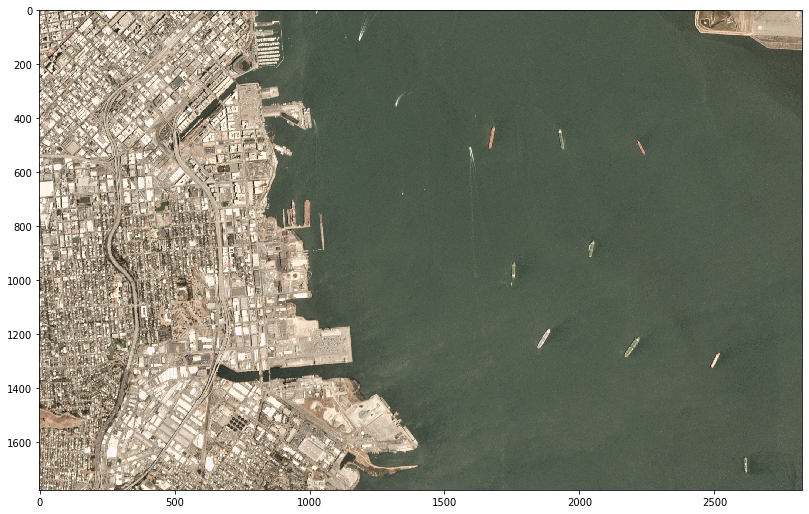

In [39]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3, 1, 1)
plt.imshow(picture_tensor)

plt.show()

In [40]:
picture_tensor = picture_tensor.transpose(2,0,1)

In [41]:
def cutting(x, y):
    area_study = np.arange(3*80*80).reshape(3, 80, 80)
    for i in range(80):
        for j in range(80):
            area_study[0][i][j] = picture_tensor[0][y+i][x+j]
            area_study[1][i][j] = picture_tensor[1][y+i][x+j]
            area_study[2][i][j] = picture_tensor[2][y+i][x+j]
    area_study = area_study.reshape([-1, 3, 80, 80])
    area_study = area_study.transpose([0,2,3,1])
    area_study = area_study / 255
    sys.stdout.write('\rX:{0} Y:{1}  '.format(x, y))
    return area_study

In [42]:
def not_near(x, y, s, coordinates):
    result = True
    for e in coordinates:
        if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
            result = False
    return result

In [43]:

def show_ship(x, y, acc, thickness=5):   
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x-th] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x+th+80] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y-th][x+i] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+th+80][x+i] = -1

X:810 Y:10  [[0.09560794 0.90439206]]


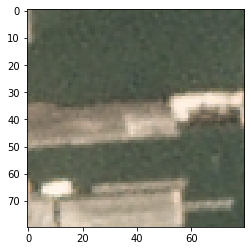

X:940 Y:320  [[0.08089146 0.9191085 ]]


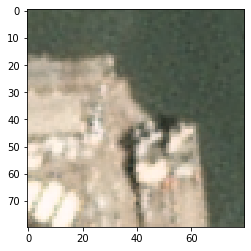

X:1640 Y:420  [[0.02705798 0.97294205]]


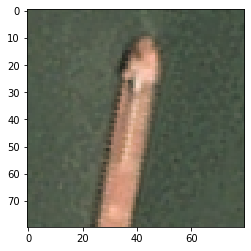

X:1890 Y:430  [[0.05609547 0.9439045 ]]


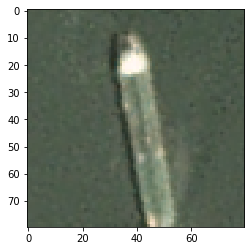

X:2190 Y:470  [[1.9366196e-05 9.9998069e-01]]


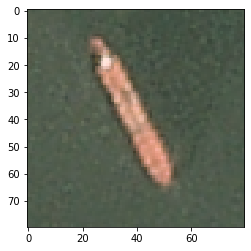

X:2000 Y:850  [[0.03579203 0.96420795]]


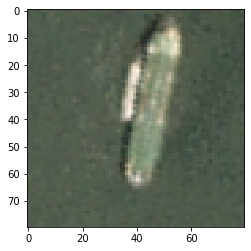

X:1720 Y:920  [[0.09376033 0.9062396 ]]


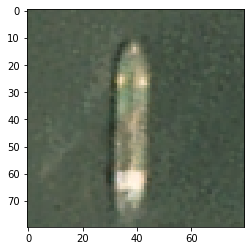

X:2460 Y:1250  [[0.09970217 0.9002978 ]]


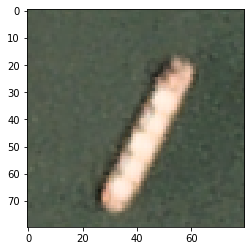

X:1230 Y:1410  [[0.05359362 0.94640636]]


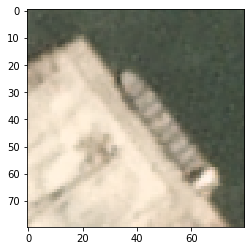

X:1300 Y:1500  [[0.05915866 0.9408413 ]]


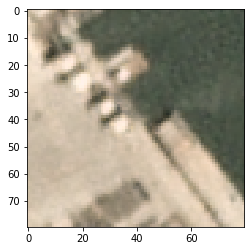

X:1220 Y:1650  [[0.07636066 0.92363936]]


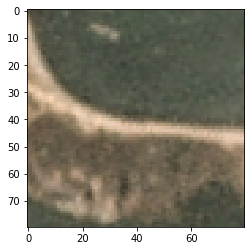

X:1310 Y:1650  [[1.773901e-04 9.998227e-01]]


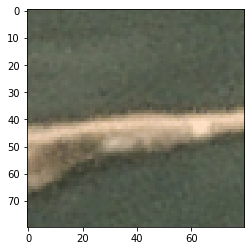

X:2740 Y:1690  

In [44]:
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        result = model.predict(area)
        if result[0][1] > 0.90 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
            print(result)
            plt.imshow(area[0])
            plt.show()

In [45]:
for e in coordinates:
    show_ship(e[0][0], e[0][1], e[1][0][1])

In [46]:
picture_tensor = picture_tensor.transpose(1,2,0)
picture_tensor.shape

(1777, 2825, 3)

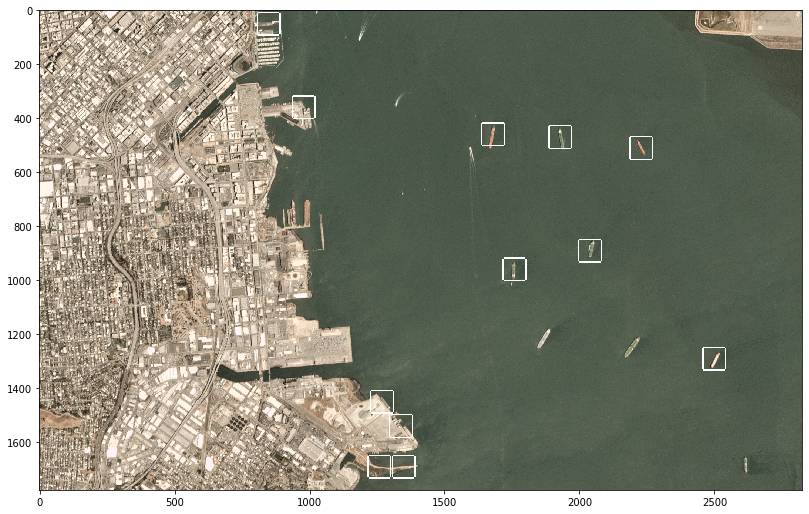

In [47]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picture_tensor)

plt.show()